In [ ]:
#| default_exp general

# General Functions

> A collection of functions and equations from the main body of ITTC


The functions in this module are not specific to any of the ITTC appendices

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
from fastcore.test import *
import pkgutil
from io import BytesIO

## Conversion between knots and meters per second

As many of the functions in this library require SI units it can be helpful to have a knots-m/s converter and vice-versa.


In [ ]:
#| export
def knots_to_ms(knots:float #the speed in knots
               ) -> float: #speed in m/s
    
    "convert knots to m/s"
    
    return knots/1.943844

In [ ]:
#| export
def ms_to_knots(ms:float #the speed in m/s
               ) -> float: #speed in knots
    
    "convert knots to m/s"
    
    return ms * 1.943844

Using these simple functions we can easily convert between knots and m/s

In [ ]:
#convert knots to m/s
meters_per_second = knots_to_ms(5)
print('speed converted to meters per second '+str(meters_per_second))
#convert back to knots
knots = ms_to_knots(meters_per_second)
print('speed converted back into knots '+str(knots))

speed converted to meters per second 2.572222873852017
speed converted back into knots 5.0


In [ ]:
#| hide
#check the two functions are invserse of each other
test_eq(ms_to_knots(knots_to_ms(5)),5)

## Wind resistance

The resistance experienced by the ship as a result of passing through air.

$$R_{AA} = \frac{1}{2} \rho_A A_{XV} \left ( C_{DA}(\psi_{WREF})  V_{WREF}^2 - C_{DA}(0)  V_{G}^2 \right),$$ 
where $\rho_A$ is the density of air, $C_{DA}$ is the wind resistance coefficient, $A_{XV}$ is the area of maximum transverse section exposed to the wind, $\psi_{WREF}$ relative direction of the wind, $V_{WREF}$ relative wind speed, and $V_G$ is the speed over ground.

The formula calculates resistance experienced by the ship when there is no wind and all resistance comes from the movement of the ship itself. This value is then subtracted from the wind resistance experienced by the ship during the trial. Put this way it is clear that the equation finds the difference between the wind resistance on a still day and on the day of the trial.

:::{.callout-note}
The ITTC manual notes that values of $C_{DA}(x)$ from the tables in `load_wind_coefficients` need to be reversed when enetering into the wind resistance formula, that is $C_{DA}= -C_x$. For consistancy the same must be done here
:::

**ITTC equations**: 9

In [ ]:
#| export
def wind_resistance(air_density:float, #Air density [kg/$m^3$]
                   wind_resistance_coef_rel:float, #the coefficient of wind resistance using the relative angle of the wind
                   wind_resistance_coef_zero:float, #the coefficient of wind resistance using angle 0 radians
                   area:float, #The maximum transverse area of the ship exposed to the wind [m^2]
                   relative_wind_speed:float, #Relative wind speed [m/s]
                   sog:float #speed over ground [m/s]
                   
                  )->float: #Air resistance [N]
    "Calculates the air resistance. N.B. SI units must be used. Do not use knots"
    
    wind_resistance_val = 0.5*air_density*area*(wind_resistance_coef_rel*relative_wind_speed**2 - wind_resistance_coef_zero*sog**2)
    
    return wind_resistance_val

What is the air resistance experienced by a cruise ferry with a tranverse area of 500$m^2$ travelling at 20 knots with a relative wind of 10 knots and a relative wind angle of $45^\circ$

In [ ]:
sog_ms = knots_to_ms(20)
wind_speed_ms = knots_to_ms(10)

wind_resistance(1.2, 0.34, 0.69, 500, wind_speed_ms, sog_ms)

-19213.8238090769

In [ ]:
#| hide

sog_ms = knots_to_ms(20)
wind_speed_ms = knots_to_ms(10)
test_close(wind_resistance(1.2, 0.34, 0.69, 500, wind_speed_ms, sog_ms),-19213, eps = 1e0 )

## Resistance due to water temperature and salinity

The temperature and salt content of the water affect its density. As such, they also affect the ship resistance. 

$$R_{AS} = R_{T0}  \left( \frac{\rho_S}{\rho_0} -1  \right) - R_F \left( \frac{C_{F0} + \Delta C_{F0}}{C_{F} + \Delta C_{F}} -1\right)$$

and

$R_F = \frac{1}{2} \rho_S S V_S^2 (C_F + \Delta C_F) $

$R_{F0} = \frac{1}{2} \rho_0 S V_S^2 (C_{F0} + \Delta C_{F0}) $

$R_{T0} = \frac{1}{2} \rho_0 S V_S^2 C_{T0} $

The below function taken from section 10.3.3 of the ITTC corrects the sea water temperature, and salt content to be that of the appropriate reference values. 

| variable    | reference value     |
|-------------|---------------------|
| temperature | $15^\circ \text{C}$ |
| Density     | 1026$kg/m^3$        |

The coefficients of roughness used in the function are derived from ITTC Recommended Procedures 7.5-02-03-01.4

The values of CF and CF0 can be obtained using the `CF_fn` function. The values of delta_CF and delta_CF0 and be found using the `roughness_allowance_fn`


**ITTC equations**: 14 to 17


In [ ]:
#| export
def temp_salinity_water_resistance(CF:float, #frictional resistance coefficient for actual water temperature and salinity
                                   CF0:float, #frictional resistance coefficient for reference water temperature and salinity
                                   delta_CF:float, #roughness allowance associated with Reynolds number for actual water temperature and salinity
                                   delta_CF0:float,#roughness allowance associated with Reynolds number for reference water temperature and salinity
                                   CT0:float, #total resistance coefficient for reference water temperature and salinity
                                   S:float, #wetted surface area [m2]
                                   stw:float, #ship’s speed through the water [m/s]
                                   rho_S:float, #water density for actual water temperature and salt content [kg/m3 ]
                                   rho_0:float = 1026 #water density for reference water temperature and salt content                                  
                                  )-> float: #resistance increase due to deviation of water temperature and water density [N]
    
    "Resistance due to water temperature and salinity corrected relative to the reference values"
    
    #This function can be re-written into sub-parts and all the sub-parts ouputted in a results matrix. 
    #Would this be useful?
    RF = 0.5 * rho_S* S * stw**2 * (CF + delta_CF)
    RT0 = 0.5 * rho_0 * S * stw**2 * CT0
    
    RAS =  RT0 * ( rho_S/rho_0 - 1 ) - RF* ( (CF0 + delta_CF0)/(CF + delta_CF) - 1 )
    
    return RAS
    

I have absolutely no idea what sensible values should look like, so this function will need to wait for beta testing, before the documentation can be complete

Also this function will probably need to point to some other functions for calculating the roughness coefficents.

In [ ]:
temp_salinity_water_resistance(CF = 1.501e-3, CF0 = 1.5e-3, delta_CF = 2.12e-4, delta_CF0 = 2.1e-4, 
                               CT0 = 1.4e-3, S = 8000, stw = 10, rho_S = 1025, rho_0 = 1026)

669.9999999998915

In [ ]:
#| hide

#both parts of the equation cancel as CF +delta_CF = CF0 +delta_CF0 AND rho_S = rho_0
test_eq(temp_salinity_water_resistance(CF = 1, CF0 = 1, delta_CF = 0.2, delta_CF0 = 0.2, CT0 = 1.4e-3, S = 2000, stw = 10, rho_S = 1026, rho_0 = 1026),0)

# CF +delta_CF = CF0 +delta_CF0 
test_eq(temp_salinity_water_resistance(CF = 1, CF0 = 1, delta_CF = 0, delta_CF0 = 0, CT0 = 2, S = 10, stw = 10, rho_S = 2, rho_0 = 1), 1000)

#densities the same
test_eq(temp_salinity_water_resistance(CF = 1, CF0 = 2, delta_CF = 0, delta_CF0 = 0, CT0 = 1.4e-3, S = 200, stw = 10, rho_S = 1, rho_0 = 1),-10000)

# Power correction for displacment

During Sea trials, vessels are usually in Ballast condition and not the laden condition for which they are built. Such a change reduces the amount of power required to propel the vessel.
If the vessel displacement during the trial is outside pre-defined limits then the power can be adjusted using the below equation based on the Admiralty formula.

$$P_2 = P_1 \left( \frac{\nabla_2}{\nabla_1} \right)^{2/3}$$

Where $P_2$ is the corrected power, $P_1$ is the ideal power during the trial, $\nabla_1$ is the displacement during the trial, and $\nabla_2$ is the displacement during tank tests.

In [ ]:
#| export

def displacement_correction(power:float, #The total ideal power during the trial [kWh],
                            trial_displacement:float, #diplacement of the ship during the trial [m^3]
                            reference_displacement:float, #diplacement of the ship during the tank test [m^3]
                            )->float: #The power corrected for the difference in displacement between the trial and the tank test
    
    """Corrects the power needed by the vessel when trial displacement differs from reference displacement"""
    return power * (reference_displacement/trial_displacement)**(2/3)

An example of the correction can be seen below

In [ ]:
trial_power = 10000.0
trial_displacement = 12000.0

# Displacement of the ship during the tank test [m^3]
reference_displacement = 15000.0

# Calculate the corrected power
corrected_power = displacement_correction(trial_power, trial_displacement, reference_displacement)

print("Corrected power:", corrected_power)

Corrected power: 11603.972084031948


In [ ]:
#| hide

def test_displacement_correction():
    # Test 1: With same trial and reference displacements
    test_result = displacement_correction(1000.0, 1500.0, 1500.0)
    test_eq(test_result, 1000.0)

    # Test 2: With different trial and reference displacements
    test_result = displacement_correction(1000.0, 1500.0, 1200.0)
    expected_result = 1000.0 * (1200.0 / 1500.0) ** (2 / 3)
    test_eq(test_result, expected_result)

    #print("All tests passed")

test_displacement_correction()

## Load example data

There are some example datasets included in this library to help with understanding the process of evaluating seatrials. Loading the data uses the following function

In [ ]:
#| export
def load_datasets(dataset:str #The name of the dataset to load
                     ): #returns a dataframe containing example data
        
        "Load example datasets to try out the pyseatrials functions"
        
        #This needs to be adapted so that the paths work on any system, using pathlib.path would be a better choice
        res = pkgutil.get_data('pyseatrials', 'datasets/'+dataset+'.csv')
        
        return pd.read_csv(BytesIO(res))

The propeller advance dataset contains the propeller advance curve for the coefficient of torque and the coefficient of thrust coefficient for an imaginary ship

In [ ]:
propeller_advance_df = load_datasets("propeller_advance_lookup")
propeller_advance_df

,J,K_T,K_Q
0,0.30,0.300,0.038
1,0.35,0.270,0.036
2,0.40,0.260,0.034
3,0.45,0.240,0.032
4,0.50,0.210,0.030
5,0.55,0.200,0.028
6,0.60,0.195,0.026
7,0.65,0.170,0.023
8,0.70,0.150,0.021
9,0.75,0.130,0.020


Plotting the dataset reveals a simple line from experimental data

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

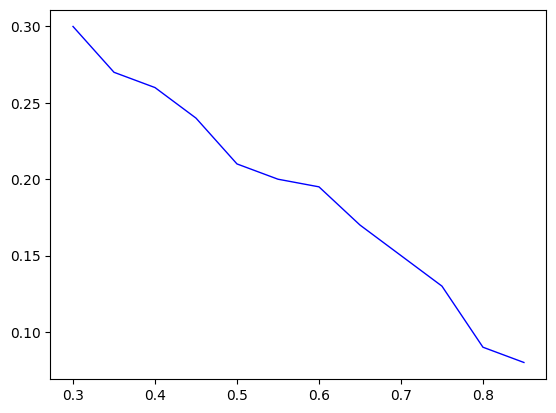

In [ ]:
plt.plot(propeller_advance_df['J'], propeller_advance_df['K_T'],'b-', lw=1, label='Linear')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()